## Team - CSS

The goal of this notebook is to create a multi-model which summarizes any kind of input i.e, text,audio, video and for wide variety of domains like news articles, social media posts, acadamic literature,etc.

This notebook code is divided into classes for single responsibility and reuse. Each od them are defined as Singilton and factory design is used to make initialization easy.

The architecture of the model is as below:
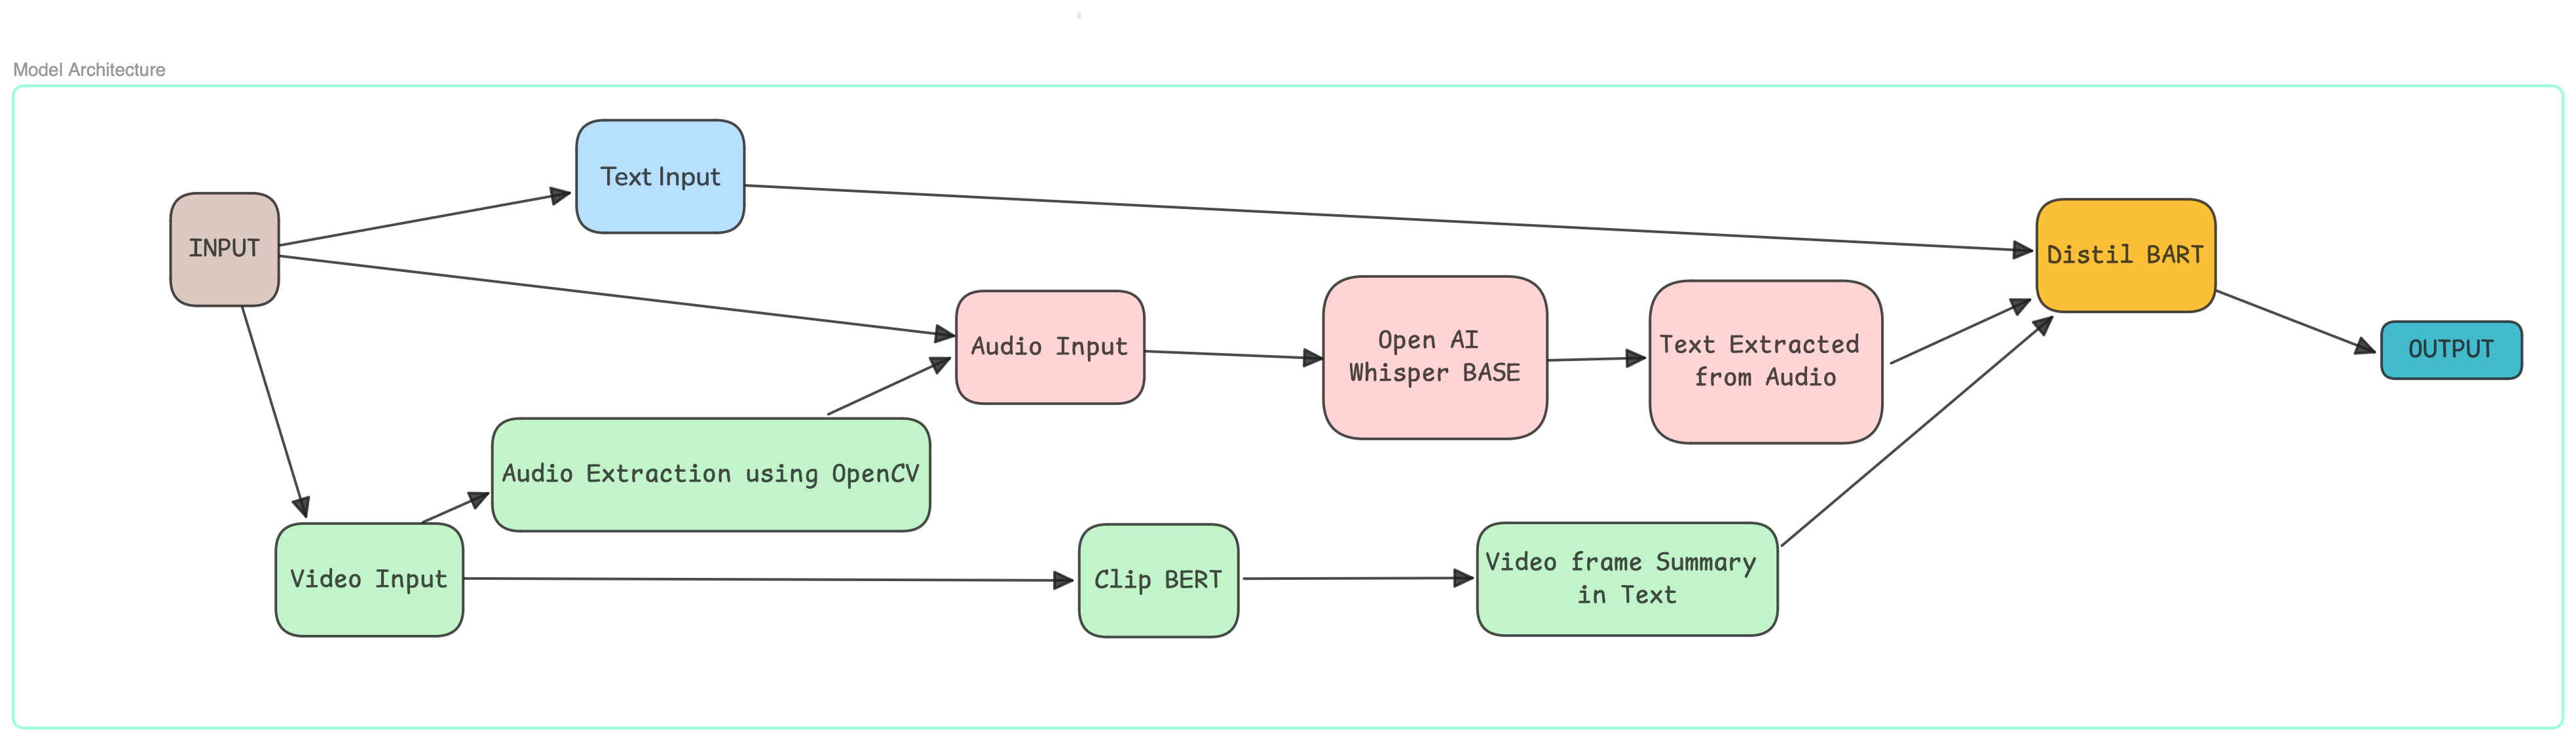

In [1]:
# Install dependencies
!pip install PyPDF2
!pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 2.0 MB/s eta 0:00:00


### Define MetaClasses

In [2]:
from abc import ABC, abstractmethod, ABCMeta
import torch

class Summarizer(ABC):

    @abstractmethod
    def summarize(self, *args, **kwargs):
        pass

class SingletonABCMeta(ABCMeta):
    _instances = {}

    def __call__(cls, *args, **kwargs):
        if cls not in cls._instances:
            cls._instances[cls] = super(SingletonABCMeta, cls).__call__(*args, **kwargs)
        return cls._instances[cls]


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Text Summarization

In [3]:
import os
from transformers import BartTokenizer, BartForConditionalGeneration
import docx
import PyPDF2


# Text summarizer for plain text, PDF, DOCX
class TextSummarizer(Summarizer, metaclass=SingletonABCMeta):
    def __init__(self, model_name="sshleifer/distilbart-cnn-12-6"):
        if not hasattr(self, 'initialized'):
            self.tokenizer = BartTokenizer.from_pretrained(model_name)
            self.model = BartForConditionalGeneration.from_pretrained(model_name).to(device)
            self.initialized = True

    # Function to read the file based on its extension
    def read_file(self,file_path):
        try:
            _, file_extension = os.path.splitext(file_path)

            if file_extension.lower() == '.txt':
                with open(file_path, 'r', encoding='utf-8') as file:
                    return file.read()
            elif file_extension.lower() == '.docx':
                doc = docx.Document(file_path)
                return ' '.join([paragraph.text for paragraph in doc.paragraphs])
            elif file_extension.lower() == '.pdf':
                with open(file_path, 'rb') as file:
                    pdf_reader = PyPDF2.PdfReader(file)
                    return ' '.join([page.extract_text() for page in pdf_reader.pages])

        except FileNotFoundError:
            print(f"Error: The file '{file_path}' was not found.")
            return None
        except Exception as e:
            print(f"Error: There was an issue reading the file '{file_path}'. Error: {str(e)}")
            return None
    # Function to split long text into smaller chunks
    def split(self,text, chunk_size=1024):
        words = text.split()
        chunks = [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]
        return chunks
    # Function to summarize a single chunk
    def summarize_chunk(self,text, max_length=200, min_length=50):
        inputs = self.tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
        summary_ids = self.model.generate(
            inputs,
            max_length=max_length,
            min_length=min_length,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True
        )
        summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary
    def summarize(self,text_path, chunk_size=1024, max_summary_length=200, min_summary_length=50):
        text = self.read_file(text_path)
        if text is None:
            return None
        # Split the text into smaller chunks
        chunks = self.split(text, chunk_size=chunk_size)
        # Summarize each chunk
        chunk_summaries = []
        for chunk in chunks:
            chunk_summary = self.summarize_chunk(chunk, max_length=max_summary_length, min_length=min_summary_length)
            chunk_summaries.append(chunk_summary)

        # Combine all chunk summaries into one document
        combined_summary_text = ' '.join(chunk_summaries)

        # Summarize the combined chunk summaries to get the final summary
        final_summary = self.summarize_chunk(combined_summary_text, max_length=max_summary_length, min_length=min_summary_length)

        return final_summary

### Audio Summarization

In [4]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torchaudio
import torch
import os


# Audio summarizer (assuming you have extracted the audio as text using Speech-to-Text)
class AudioSummarizer(Summarizer, metaclass=SingletonABCMeta):
    def __init__(self, model_name="openai/whisper-base"):
        if not hasattr(self, 'initialized'):
            self.processor = WhisperProcessor.from_pretrained(model_name)
            self.model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)
            self.initialized = True
    # Function to split audio into chunks of a specific length (in seconds)
    def split(self,audio, chunk_length_sec, sample_rate):
        chunk_length_samples = chunk_length_sec * sample_rate
        num_chunks = int(audio.shape[1] // chunk_length_samples) + 1
        chunks = torch.split(audio, int(chunk_length_samples), dim=1)
        return chunks

    def summarize_chunk(self, audio_chunk, device):
        # Normalize audio input
        audio_chunk = (audio_chunk - audio_chunk.mean()) / torch.sqrt(audio_chunk.var() + 1e-7)

        # Process audio into input format for Whisper
        input_features = self.processor(audio_chunk.squeeze().numpy(), return_tensors="pt", sampling_rate=16000).input_features.to(device)

        # Generate transcription
        with torch.no_grad():
            predicted_ids = self.model.generate(input_features)

        # Decode predicted tokens into text
        transcription = self.processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

        return transcription


    def transcribe_audio(self, audio_path):
        # Load audio
        audio_input, sample_rate = torchaudio.load(audio_path)

        # Resample if necessary
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(sample_rate, 16000)
            audio_input = resampler(audio_input)

        # Convert to mono if stereo
        if audio_input.shape[0] > 1:
            audio_input = torch.mean(audio_input, dim=0, keepdim=True)

        # Split the audio into chunks
        audio_chunks = self.split(audio_input, chunk_length_sec=30, sample_rate=16000)

        # Transcribe each chunk and accumulate results
        transcription = ""
        for chunk in audio_chunks:
            chunk_transcription = self.summarize_chunk(chunk, Summarizer.device)
            transcription += chunk_transcription + " "  # Add a space between chunks

        return transcription.strip()

    def summarize(self, audio_path):
        audio_text = self.transcribe_audio(audio_path)
        # Write the transcribed text to a temporary text file
        temp_file_path = "temp_audio_transcription.txt"
        with open(temp_file_path, 'w') as temp_file:
            temp_file.write(audio_text)
        try:
            summary = TextSummarizer().summarize(temp_file_path)
        finally:
            # Delete the temporary text file after summarization
            if os.path.exists(temp_file_path):
                os.remove(temp_file_path)

        # Return the summary
        return summary

### Video Summarization

In [5]:
from moviepy.editor import VideoFileClip
import cv2
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import torch
import os


# Video summarizer (handles frame extraction and audio extraction)
class VideoSummarizer(Summarizer, metaclass=SingletonABCMeta):
    def __init__(self):
        if not hasattr(self, 'initialized'):
            self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
            self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
            self.initialized = True
    # Extract Audio from Video using moviepy
    def extract_audio_from_video(self,video_path):
        video = VideoFileClip(video_path)
        audio_path = video_path.replace('.mp4', '.wav')  # Temporary audio file, for now in the intrest in time, we are only considering mp4
        video.audio.write_audiofile(audio_path)
        return audio_path
    # Extract Frames from the Video
    def extract_frames(self,video_path, frame_rate=1):
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = 0
        fps = cap.get(cv2.CAP_PROP_FPS)

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            if frame_count % int(fps // frame_rate) == 0:
                frames.append(frame)

            frame_count += 1
        cap.release()
        return np.array(frames)

    # Convert Frames to PIL images
    def frames_to_pil(self,frames):
        pil_images = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in frames]
        return pil_images

    # Summarize Video with ClipBERT (Visual)
    def summarize_visual(self,frames):
        pil_images = self.frames_to_pil(frames)

        inputs = self.processor(images=pil_images, return_tensors="pt", padding=True)
        with torch.no_grad():
            visual_features = self.model.get_image_features(**inputs)

        # Placeholder for actual visual summary
        visual_summary = "The visual content of the video includes: " + " ".join(["scene" for _ in frames]) + "."

        return visual_summary
    # Transcribe and Summarize Audio (above code)
    # Combine Visual and Audio Summaries
    def summarize(self, video_path):
        # Extract visual frames
        frames = self.extract_frames(video_path, frame_rate=1)

        # Summarize visual content
        visual_summary = self.summarize_visual(frames)

        # Extract audio path and summarize audio content
        audio_path = self.extract_audio_from_video(video_path)
        # audio_summary = summarize_audio(audio_path)
        audio_transcription = AudioSummarizer().transcribe_audio(audio_path)


        # Combine audio transcription and visual description into one text
        combined_text = f"Audio transcription: {audio_transcription}\nVisual description: {visual_summary}"

        temp_file_path = "combined_text.txt"
        with open(temp_file_path, 'w') as temp_file:
            temp_file.write(combined_text)
        try:
            final_summary = TextSummarizer().summarize(temp_file_path)
        finally:
            # Delete the temporary text file after summarization
            if os.path.exists(temp_file_path):
                os.remove(temp_file_path)
            if os.path.exists(audio_path):
                os.remove(audio_path)

        return final_summary

### Glue Classes for initialization and usage

In [6]:
import os

class FileTypeRecognizer:
    @staticmethod
    def recognize(file_path):
        _, file_extension = os.path.splitext(file_path)
        file_extension = file_extension.lower()

        if file_extension in ['.txt', '.pdf', '.docx']:
            return 'text'
        elif file_extension in ['.mp3', '.wav']:
            return 'audio'
        elif file_extension in ['.mp4', '.avi']:
            return 'video'
        else:
            raise ValueError(f"Unsupported file type: {file_extension}")

In [7]:
class SummarizerFactory:
    @staticmethod
    def get_summarizer(file_type):
        if file_type == 'text':
            return TextSummarizer()
        elif file_type == 'audio':
            return AudioSummarizer()
        elif file_type == 'video':
            return VideoSummarizer()
        else:
            raise ValueError(f"Unsupported file type: {file_type}")

In [8]:
class FileProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.file_type = FileTypeRecognizer.recognize(file_path)
        self.summarizer = SummarizerFactory.get_summarizer(self.file_type)

    def process(self):
        return self.summarizer.summarize(self.file_path)

In [9]:
import argparse
import sys


def process_file(file_path):
    try:
        file_processor = FileProcessor(file_path)
        summary = file_processor.process()
        print(f"Summary for {file_path}:\n{summary}\n")
    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

def main():
    # Setup argument parser
    parser = argparse.ArgumentParser(description="Summarize text, audio, or video files.")

    # Define the expected arguments
    parser.add_argument('--text', type=str, help="Path to a text file (PDF, TXT, DOCX)")
    parser.add_argument('--audio', type=str, help="Path to an audio file (MP3)")
    parser.add_argument('--video', type=str, help="Path to a video file (MP4)")

    # Parse the arguments
    args = parser.parse_args()

    # Process the corresponding file based on the provided argument
    if args.text:
        print(f"Processing text file: {args.text}")
        process_file(args.text)
    elif args.audio:
        print(f"Processing audio file: {args.audio}")
        process_file(args.audio)
    elif args.video:
        print(f"Processing video file: {args.video}")
        process_file(args.video)
    else:
        print("Please provide a valid argument (--text, --audio, or --video) and the corresponding file path.")

### Outputs

**Note:** The models are runing using **CPU** due to the interest in resource allocation.

#### Text Outputs

In [10]:
if __name__ == "__main__":
    # Simulating command-line argument passing for text
    sys.argv = ['script_name', '--text', 'tp.txt'] # News Article
    main()

Processing text file: tp.txt


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Summary for tp.txt:
 Video shows a shadowy figure emerging on top of the American Glass Research (AGR) complex building at 6:08 p.m. A police officer's bodycam captures the figure walking in a green area on the east side of the AGR complex, near the water tower, when his body camera captures who is believed to be Crooks, 20, roof-hopping. Crooks got off eight shots while trying to take out Trump, according to a preliminary report released by Rep. Clay Higgins, R-La.



In [11]:
if __name__ == "__main__":
    # Simulating command-line argument passing for text
    sys.argv = ['script_name', '--text', 'acadamic.pdf'] # Acadamic Paper 10 pages, no reinitialization of model
    main()

Processing text file: acadamic.pdf
Summary for acadamic.pdf:
 Current self-driving cars use camera, lidar data and make decisions and drive on roads. But if all vehicles are connected and talk to each other forming vehicular networks that would drastically improve the accuracy of automated driving. Smart cars can also communicate with traffic lights, parking, and other object-ID parts of smart cities to create a faster and more adaptive ecosystem.



#### Audio Outputs

In [12]:
if __name__ == "__main__":
    # Simulating command-line argument passing for audio
    sys.argv = ['script_name', '--audio', 'news.mp3'] # 5min 19sec
    main()

Processing audio file: news.mp3


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.81k [00:00<?, ?B/s]

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Summary for news.mp3:
 658 cases of cholera have been reported since the 12th of August with 28 deaths. Sudan is also experiencing multiple simultaneous disease outbreaks, with malaria, measles and dengue. UN's top aid official in the occupied Palestinian territory warns that massive evacuations in Gaza choked people's survival.



#### Video Summary

In [14]:
if __name__ == "__main__":
    # Simulating command-line argument passing for video
    sys.argv = ['script_name', '--video', 'mo.mp4'] # Social Media - Youtube video - https://www.youtube.com/watch?v=o2fwg4RnBfU
    main()

Processing video file: mo.mp4
MoviePy - Writing audio in mo.wav


MoviePy - Done.
Summary for mo.mp4:
 Rebecca Param: "I've never been averse to a little bit of blood. But my big injury story that I always tell people happened when I was very young. I had bitten through my top lip which left this handsome little scar later and the force of the fall had pushed my front teeth back and up into my head. Thankfully, thankfully, thankfully. I've finally got these chompers under control, but who could blame them after going through such misery?

